code being adapted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [2]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance

In [3]:
import seaborn as sns

In [4]:
seed = 42

In [ ]:
# noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)

# noisy_moons = datasets.make_moons(n_samples=(n_samples,3), noise=0.05, random_state=seed)

# biclusters, r, c = datasets.make_biclusters(
#     shape=(n_samples, n_features), n_clusters=2, random_state=seed,noise=10
# )

# # # Anisotropicly distributed data
# X, y = datasets.make_blobs(n_samples=n_samples,n_features=2, random_state=seed)
# transformation = [[0.6, -0.6], [-0.4, 0.8]]
# X_aniso = np.dot(X, transformation)
# aniso = (X_aniso, y)


In [5]:
n_samples = 1000
n_features = 3

gaus_homosk_blobs = datasets.make_blobs(n_samples=n_samples,n_features=n_features, random_state=seed)

gaus_heterosk_blobs = datasets.make_blobs(
    n_samples=n_samples,n_features=n_features, cluster_std=[2.0, 2.5, 0.5], random_state=seed
)

swissrolldata = datasets.make_swiss_roll(
    n_samples=n_samples,random_state=seed,noise=0.2
)


In [6]:
# ellips_homosk_clusters[1]

In [10]:
def make_heteroskedastic_anisotropic_blobs_nd(
    n_samples=1000,
    n_features=3,
    cluster_std=1.0,
    transforms=None,
    random_state=seed,
):
    
    if isinstance(cluster_std, float):
        num_center = 1
    elif isinstance(cluster_std, list):
        num_center = len(cluster_std)
    else:
        # raise error
        return

    X, y = datasets.make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        cluster_std=cluster_std,
        random_state=random_state,
        centers=num_center
    )

    rng = np.random.RandomState(random_state)
    unique_labels = np.unique(y)

    if transforms is None:
        transforms = {
            label: rng.randn(n_features, n_features)*3.0
            for label in unique_labels
        }

    X_transformed = np.zeros_like(X)
    for label in unique_labels:
        T = transforms[label]
        X_transformed[y == label] = X[y == label] @ T.T

    return X_transformed, y, transforms


In [11]:
ellips_homosk_clusters = make_heteroskedastic_anisotropic_blobs_nd(cluster_std=[1.0,1.0,1.0])

In [12]:
ellips_heterosk_clusters = make_heteroskedastic_anisotropic_blobs_nd(cluster_std=[1.0,0.3,2.0])

In [13]:
def generate_noisy_nd_grid(grid_points_per_dim=10, n_dims=3, spacing=1.0, noise_std=0.1, seed=None):

    rng = np.random.default_rng(seed)

    if isinstance(grid_points_per_dim, int):
        grid_points_per_dim = [grid_points_per_dim] * n_dims
    elif len(grid_points_per_dim) != n_dims:
        raise ValueError("Length of grid_points_per_dim must match n_dims")

    # Create clean grid
    grid_pts = [np.linspace(0, (n - 1) * spacing, n) for n in grid_points_per_dim]
    mesh = np.meshgrid(*grid_pts, indexing='ij')
    grid = np.stack(mesh, axis=-1).reshape(-1, n_dims)

    # Add Gaussian noise
    # TODO: VARY NOISE / HETEROSKEDASTIC
    noise = rng.normal(scale=noise_std, size=grid.shape)
    noisy_grid = grid + noise

    return noisy_grid


In [14]:
def noisy_torus(n_samples=1000, R=2, r=1, noise=0.2, random_state=None, center=(0, 0, 0)):
    rng = np.random.default_rng(random_state)
    
    # Sample angles u, v uniformly
    u = rng.uniform(0, 2 * np.pi, n_samples)
    v = rng.uniform(0, 2 * np.pi, n_samples)
    
    # Parametric equations
    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)
    
    # Add Gaussian noise if requested
    if noise > 0:
        x += rng.normal(0, noise, n_samples)
        y += rng.normal(0, noise, n_samples)
        z += rng.normal(0, noise, n_samples)
    
    return np.stack([x, y, z], axis=1)


In [15]:
def noisy_concentric_spheres(n_samples=1000,n_features=3,n_spheres=4,noise=0.2, center=(0, 0, 0), radii_arr=None):
    
    if radii_arr is None:
        scale_factor = 50
        radii_arr = np.linspace(1, n_spheres*scale_factor,n_spheres + 1)

    n_samples_per_shell = int(n_samples / n_spheres)
    rng = np.random.default_rng(seed)

    X_list = []

    for i, r in enumerate(radii_arr):

        # sample spherical coords
        theta = rng.uniform(0, 2 * np.pi, n_samples_per_shell)
        phi = np.arccos(rng.uniform(-1, 1, n_samples_per_shell))
        
        r_noisy = r + rng.normal(0, noise, n_samples_per_shell)
        
        r_noisy_x = r_noisy
        r_noisy_y = r_noisy
        r_noisy_z = r_noisy

        # convert to feature vector
        x = r_noisy_x * np.sin(phi) * np.cos(theta)
        y = r_noisy_y * np.sin(phi) * np.sin(theta)
        z = r_noisy_z * np.cos(phi)
        
        shell_points = np.stack([x, y, z], axis=1)
        X_list.append(shell_points)
    
    X = np.vstack(X_list)

    return X

In [16]:
noisy_concentric_sph = noisy_concentric_spheres()

In [17]:
noisy_torus = noisy_torus()

In [18]:
gauss_noise_grid = generate_noisy_nd_grid()

/tmp/ipykernel_7069/1473030180.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


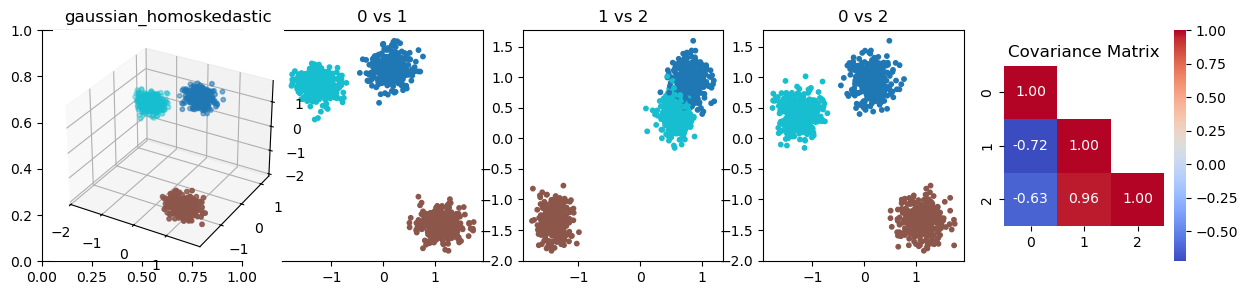

/tmp/ipykernel_7069/1473030180.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


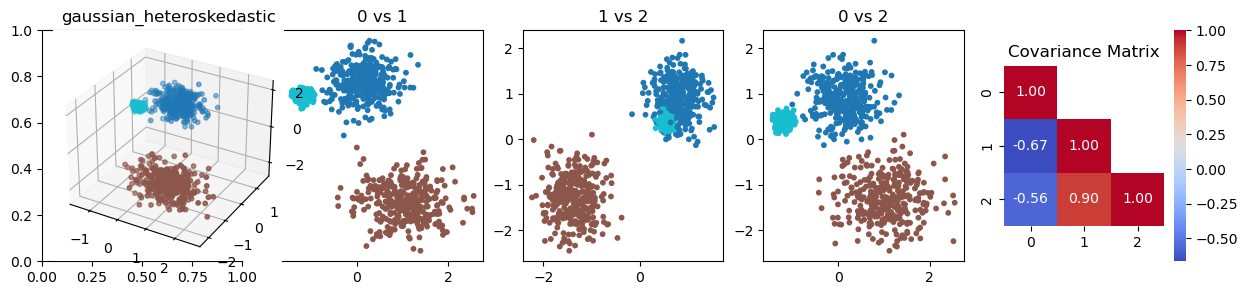

/tmp/ipykernel_7069/1473030180.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


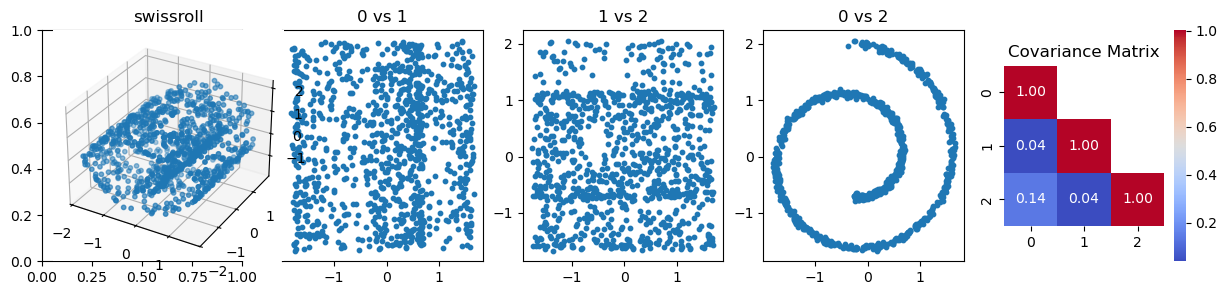

/tmp/ipykernel_7069/1473030180.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


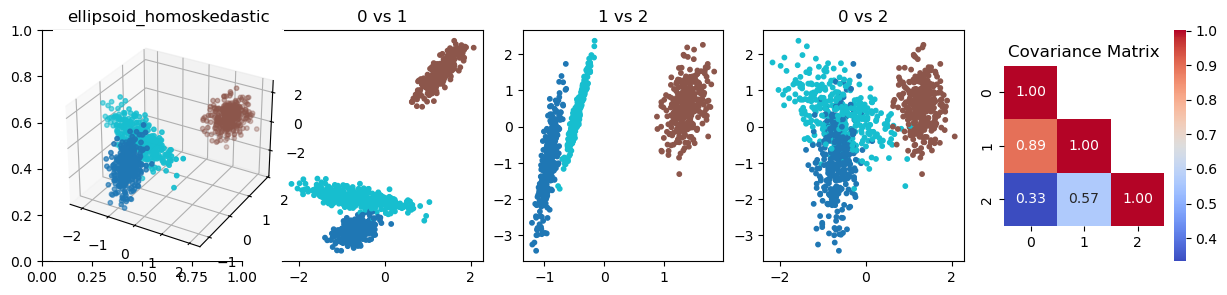

/tmp/ipykernel_7069/1473030180.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


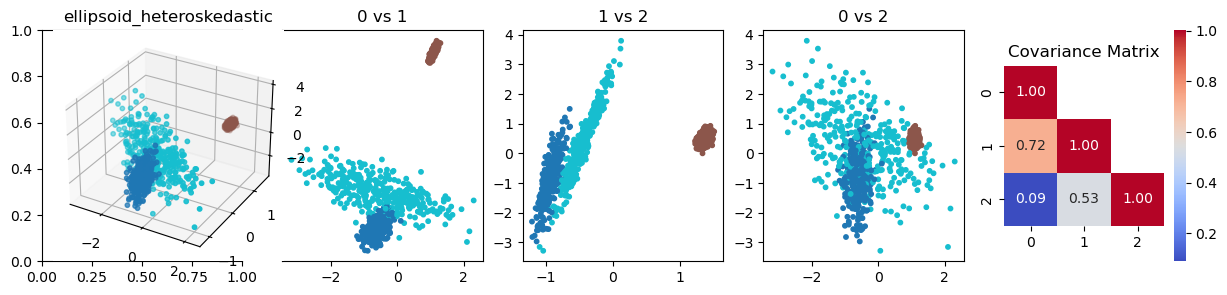

/tmp/ipykernel_7069/1473030180.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


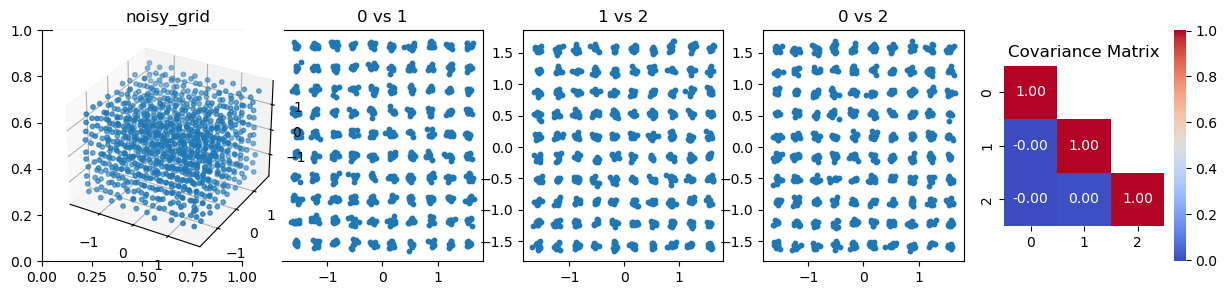

/tmp/ipykernel_7069/1473030180.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


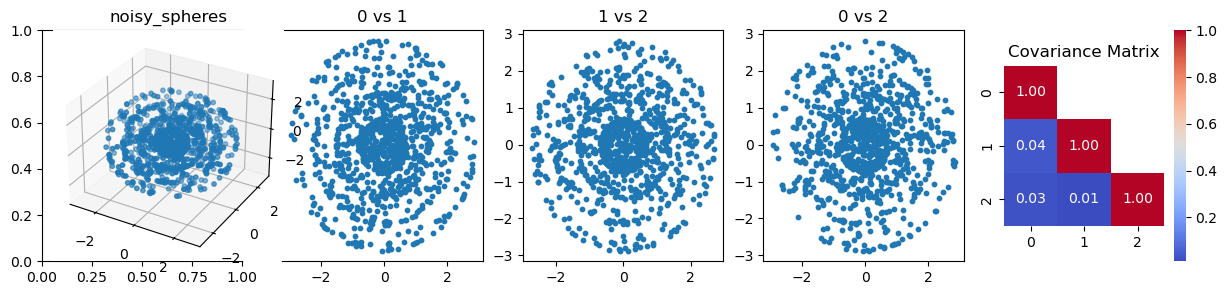

/tmp/ipykernel_7069/1473030180.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


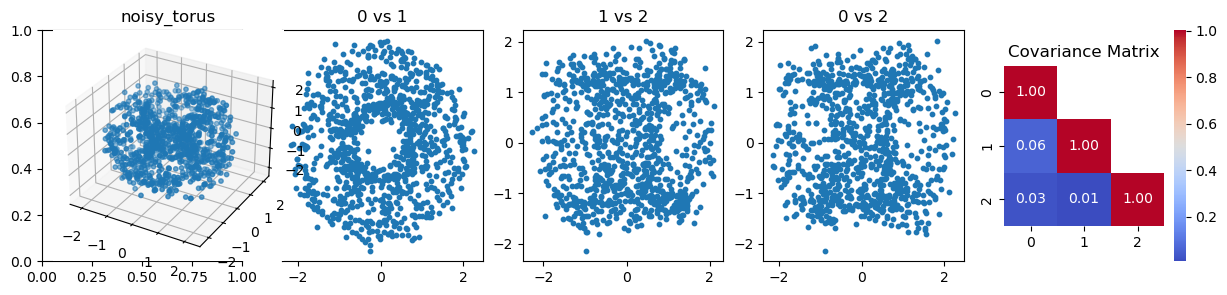

In [19]:
dataset_lst = [
    (gaus_homosk_blobs[0],{'name' : 'gaussian_homoskedastic',
                           'class_label' : gaus_homosk_blobs[1]},),
    (gaus_heterosk_blobs[0], {'name' : 'gaussian_heteroskedastic',
                           'class_label' : gaus_heterosk_blobs[1]}),
    (swissrolldata[0], {'name' : 'swissroll'}),
    (ellips_homosk_clusters[0],{'name' : 'ellipsoid_homoskedastic',
                                'class_label' : ellips_homosk_clusters[1]}),
    (ellips_heterosk_clusters[0],{'name' : 'ellipsoid_heteroskedastic',
                                'class_label' : ellips_heterosk_clusters[1]}),
    (gauss_noise_grid,{'name' : 'noisy_grid',
                        }),
    (noisy_concentric_sph,{'name' : 'noisy_spheres',
                        }),
    (noisy_torus,{'name' : 'noisy_torus',
                        }),

]

for i_dataset, (dataset_val, params_dict) in enumerate(dataset_lst):
    X = dataset_val

    y = None
    if 'class_label' in params_dict.keys():
        y = params_dict['class_label']

    def scatter_helper(ax, xs, ys, zs=None, class_label = None):

        if zs is not None:
            if class_label is not None:
                sc = ax.scatter(xs, ys, zs, c=class_label, cmap='tab10', s=10)
            else:
                sc = ax.scatter(xs, ys, zs, s=10)
            return sc

        else:
            if class_label is not None:
                sc = ax.scatter(xs, ys, c=class_label, cmap='tab10', s=10)
            else:
                sc = ax.scatter(xs, ys, s=10)
            return sc
        
        return None

    # normalize dataset
    X = StandardScaler().fit_transform(X)

    # fig = plt.figure()    
    fig, axs = plt.subplots(1, 5, figsize=(15, 3), subplot_kw={})

    axs[0] = fig.add_subplot(1, 4, 1, projection='3d')
    xs,ys,zs = X[:, 0], X[:, 1], X[:, 2]
    scatter_helper(axs[0],xs,ys,zs,y)
    axs[0].set_title(params_dict['name'])

    # 2D scatter plots
    scatter_helper(axs[1],xs,ys,None,y)
    axs[1].set_title('0 vs 1')

    scatter_helper(axs[2],ys,zs,None,y)
    axs[2].set_title('1 vs 2')

    scatter_helper(axs[3],xs,zs,None,y)
    axs[3].set_title('0 vs 2')

    cov_mat = np.cov(X, rowvar=False)
    mask = np.triu(np.ones_like(cov_mat, dtype=bool), k=1)    
    sns.heatmap(cov_mat, mask=mask,ax=axs[4], cbar=True, square=True,
                annot=True, fmt=".2f", cmap="coolwarm")
    axs[4].set_title('Covariance Matrix')
        
    # plt.xlim(-2.5, 2.5)
    # plt.ylim(-2.5, 2.5)

    plt.tight_layout()
    plt.show()


In [14]:
# X[:,0].shape